In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"],
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()


# LOAD QPU

In [4]:
import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits

fuck
LOADED: ./qpu_parameters/20260203-2336_co_spec0203


In [5]:
qubits[0].parameters
buses[0].parameters

BusCavityParameters(
│   custom={},
│   rip_amplitude=1.0,
│   rip_length=1e-06,
│   rip_pulse={
│   │   'function': 'NestedCosine'
│   },
│   rip_detuning=-13000000.0,
│   drive_lo_frequency=5400000000.0,
│   drive_range=10,
│   spectroscopy_length=0.0001,
│   spectroscopy_amplitude=1,
│   spectroscopy_pulse={
│   │   'can_compress': True,
│   │   'function': 'const'
│   },
│   resonance_frequency_bus=5501600000.0,
│   kappa=None
)


In [6]:
from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

# Connection

In [7]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.04 00:31:45.574] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.04 00:31:45.576] INFO    VERSION: laboneq 25.10.3
[2026.02.04 00:31:45.577] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.04 00:31:45.693] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.04 00:31:45.779] INFO    Configuring the device setup
[2026.02.04 00:31:45.897] INFO    The device setup is configured


In [8]:
# qubits[0].parameters.resonance_frequency_ge = 4.20757e9
# qubits[0].parameters.drive_lo_frequency = 4.2e9
# qubits[0].parameters.drive_range = 10
# qubits[0].parameters.ge_drive_amplitude_pi = 0.4353#0.4807
# qubits[0].parameters.ge_drive_amplitude_pi2 = 0.2390
# qubits[0].parameters.ge_drive_length = 128e-9

# #---READOUT--#
# qubits[0].parameters.readout_amplitude = 0.5
# qubits[0].parameters.readout_resonator_frequency = 7.0021e9 #disp shift 로 얻어짐
# qubits[0].parameters.readout_length = 1.3e-6
# qubits[0].parameters.readout_integration_delay = 500e-9
# qubits[0].parameters.readout_integration_length = 1.3e-6
# qubits[0].parameters.readout_lo_frequency = 7.0e9
# qubits[0].parameters.readout_range_out = 0
# qubits[0].parameters.readout_range_in = 0
# qubits[0].parameters.reset_delay_length = 200e-6


#buses[0].parameters.drive_lo_frequency 
# buses[0].parameters.drive_range = 10
# buses[0].parameters.resonance_frequency_bus = 5.5016e9

# Ramsey Echo

In [ ]:
from experiments import echo 

q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,20e-6,301)
detunings = 0.5e6,
pprint(q.readout_parameters())
#######################################################################
options = echo.experiment_workflow.options()
options.update(False)
options.count(1024)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = echo.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    #detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
#ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q1']

# Ramsey

In [ ]:
from laboneq_applications.experiments import ramsey

q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
#temp_pars.readout_integration_length= 1e-6
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,10e-6,301)
detunings = 0.4e6 #4e6,
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(True)
options.count(512)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
#ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q0']

In [ ]:
qubits[0].parameters.resonance_frequency_ge

# Power calculation

In [ ]:
buses[0].parameters.drive_range

In [ ]:
from helper import adjust_amplitude_for_output_range, calculate_power
adjust_amplitude_for_output_range(initial_output_dbm=-10, initial_amplitude= 0.0032, new_output_dbm=-30)
calculate_power(output_dbm=-30, amplitude=0.021,attenuation=[])

# Coherence Spectroscopy

ECHO 제거함

In [ ]:
# qubits[4].parameters.resonance_frequency_ge = 6.4203e9 #mode3
# qubits[2].parameters.resonance_frequency_ge = 5.4947e9 #mode1

# qubits[2].parameters.readout_integration_delay = 320e-9

('measure', {'amplitude': 0.5, 'length': 1.3e-06, 'pulse': {'function': 'GaussianSquare', 'risefall_sigma_ratio': 3.0, 'sigma': 0.2}})
[2026.02.04 00:31:57.349] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.04 00:31:57.349] INFO      Workflow 'coherence_spectroscopy': execution started at 2026-02-03            
[2026.02.04 00:31:57.350] INFO      15:31:57.349050Z                                                              
[2026.02.04 00:31:57.350] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.04 00:31:57.361] INFO    Task 'temporary_qpu': started at 2026-02-03 15:31:57.361240Z
[2026.02.04 00:31:57.362] INFO    Task 'temporary_qpu': ended at 2026-02-03 15:31:57.362364Z
[2026.02.04 00:31:57.365] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-03 
[2026.02.04 00:31:57.365] INFO    15:31:57.365495Z
[2026.02.04 00:31:57.366] INFO    Task 'temporary_quantum_element

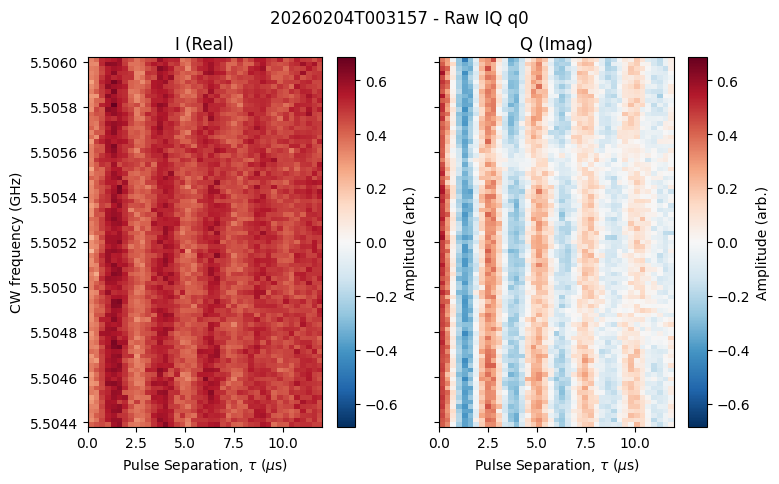

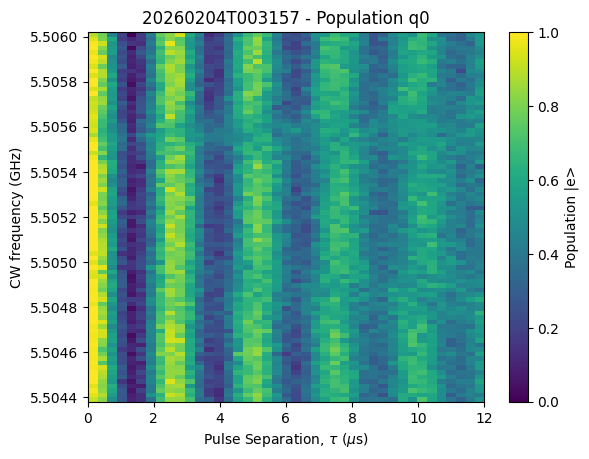

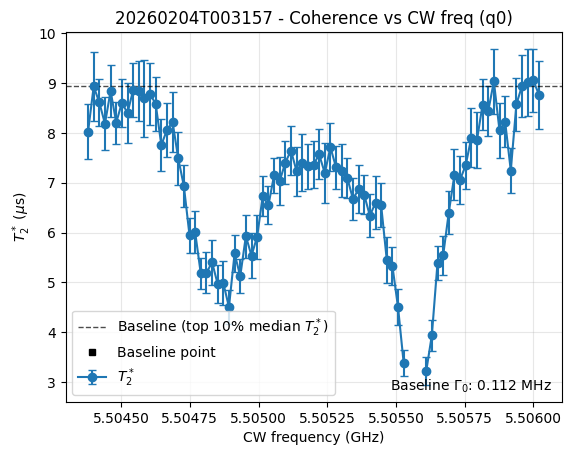

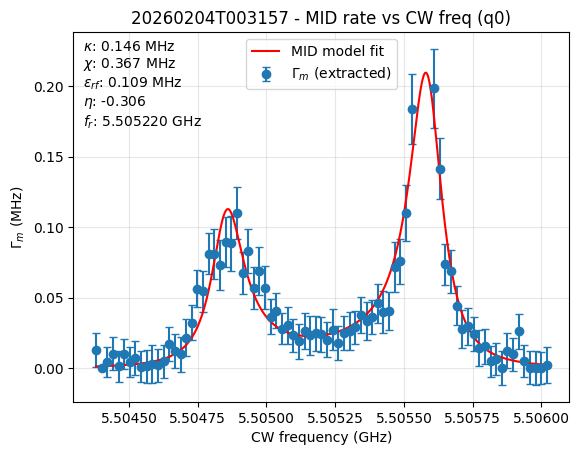

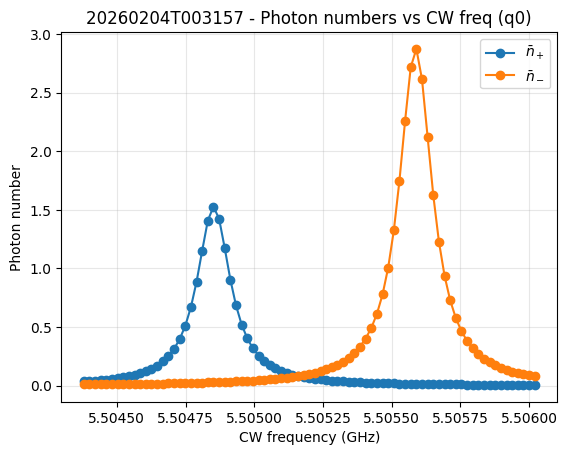

In [9]:
from experiments import new_coherence_spectroscopy


####################################################################################
q=qubits[0]
b=buses[0]
temporary_parameters = {}
q_temp_pars =deepcopy(q.parameters)
b_temp_pars =deepcopy(b.parameters)
#q_temp_pars.drive_range = 10
b_temp_pars.drive_range = -30
#b_temp_pars.readout_integration_length =1e-6
# b_temp_pars.drive_lo_frequency = 6.0e9
temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[b.uid] = b_temp_pars

print(q.readout_parameters())

#####################################################################################
options = new_coherence_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(256)
options.update(False)
options.do_analysis(True)
options.ring_up(50.0e-6)
options.ring_down(10e-9)
options.readout_section_length(100e-6)

######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
co_spec = new_coherence_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    bus= b,
    delays=np.linspace(0,12e-6,41), #delays=np.linspace(0,5e-6,21), 포인트 확보 중요
    #CW_frequencies= b.parameters.resonance_frequency_bus+np.linspace(-4.0e6,4.0e6,201),
    CW_frequencies= 5.5052e9+np.linspace(-0.82e6,0.82e6,81),
    #CW_frequencies= 5.5555e9 +np.linspace(-0.6e6,0.6e6,101),
    CW_amplitude=0.03,
    CW_phase=0.0,
    detunings=0.4e6,
    temporary_parameters=temporary_parameters,
    options=options
)
co_spec_result = co_spec.run()
#co_spec_analysis_result = co_spec_result.tasks["analysis_workflow"]

n_plus  *= (1 + eta)
n_minus *= (1 - eta)

In [ ]:
co_spec_analysis_result = co_spec_result.tasks["analysis_workflow"]
fit = co_spec_analysis_result.tasks['fit_mid_rate_data'].output['q1']
fit.best_values

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=co_spec_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=10000)
#plot_simulation(compiled_experiment=co_spec_result.tasks["compile_experiment"].output, length=250e-6)

# Checking power dependece 

[2026.02.04 00:54:16.817] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.04 00:54:16.818] INFO      Workflow 'coherence_spectroscopy': execution started at 2026-02-03            
[2026.02.04 00:54:16.818] INFO      15:54:16.817136Z                                                              
[2026.02.04 00:54:16.818] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.04 00:54:16.838] INFO    Task 'temporary_qpu': started at 2026-02-03 15:54:16.838476Z
[2026.02.04 00:54:16.839] INFO    Task 'temporary_qpu': ended at 2026-02-03 15:54:16.839696Z
[2026.02.04 00:54:16.842] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-03 
[2026.02.04 00:54:16.842] INFO    15:54:16.842337Z
[2026.02.04 00:54:16.843] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-03 15:54:16.843074Z
[2026.02.04 00:54:16.844] INFO    Task 'temporary_quantum_elements_from_qpu': started

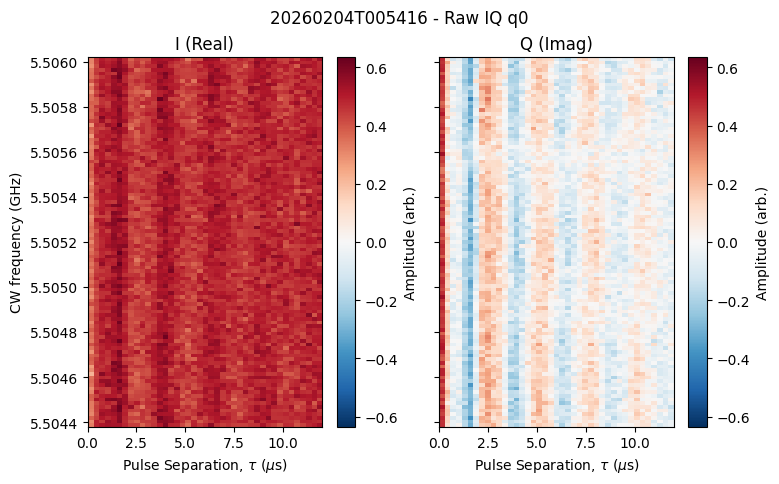

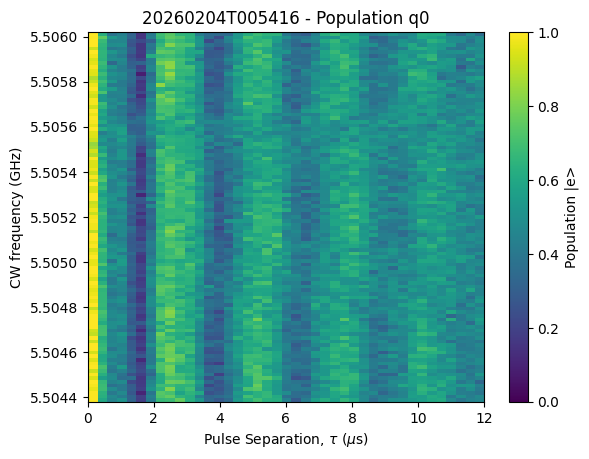

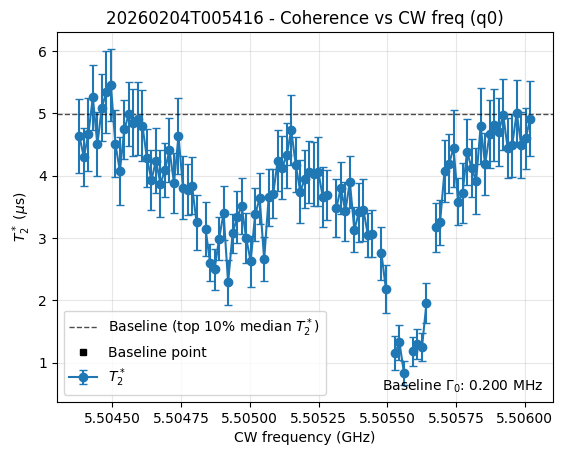

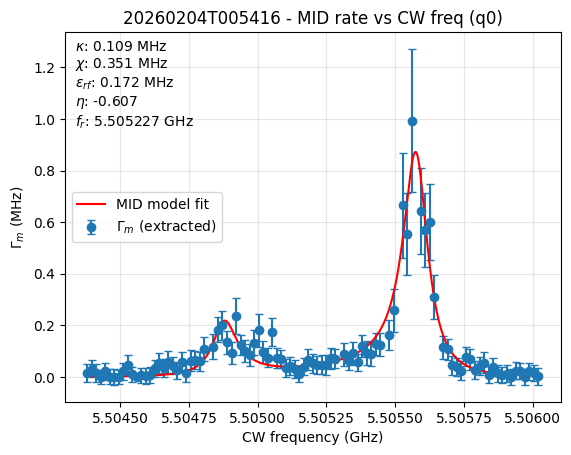

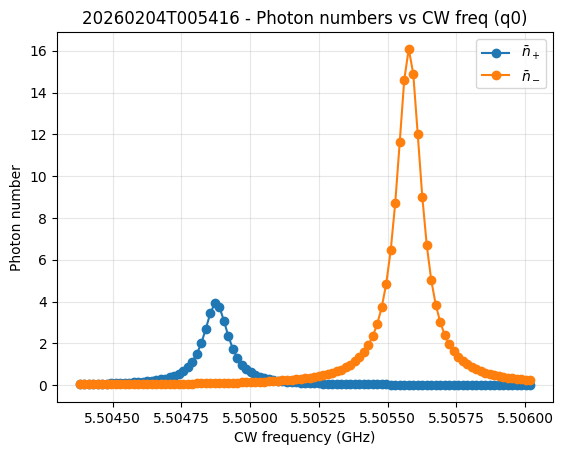

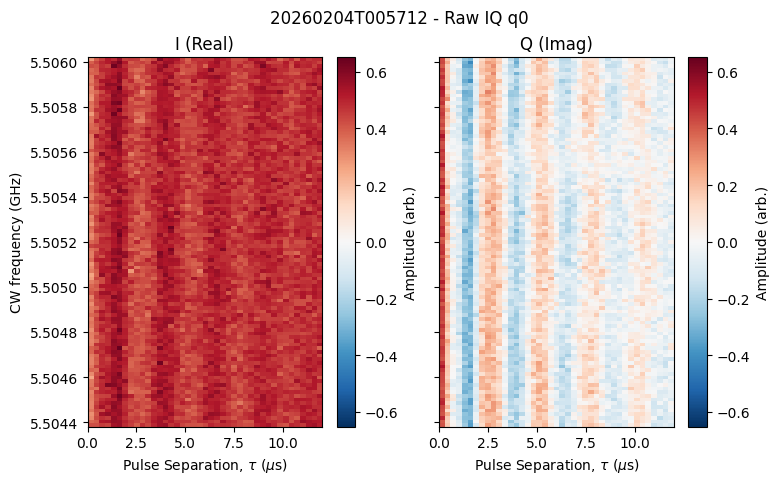

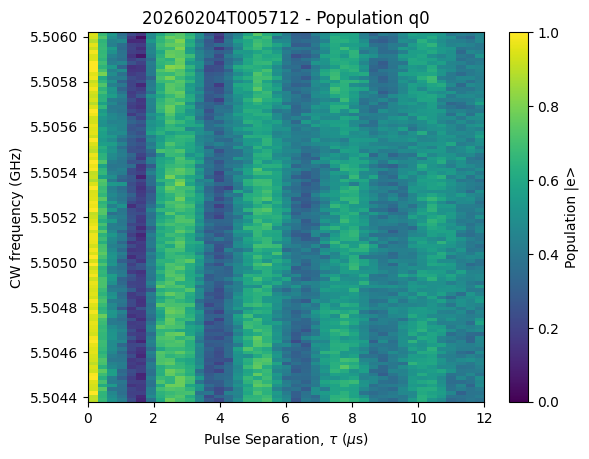

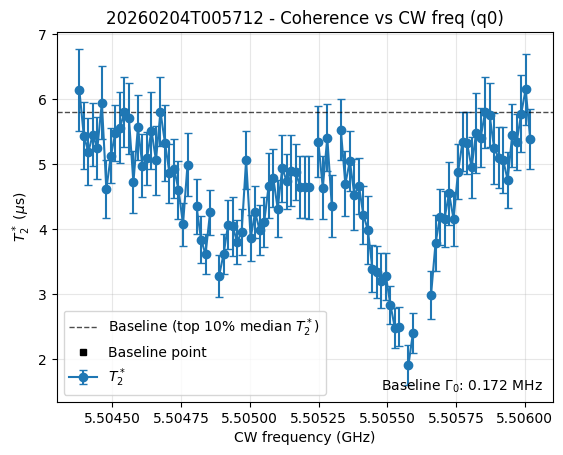

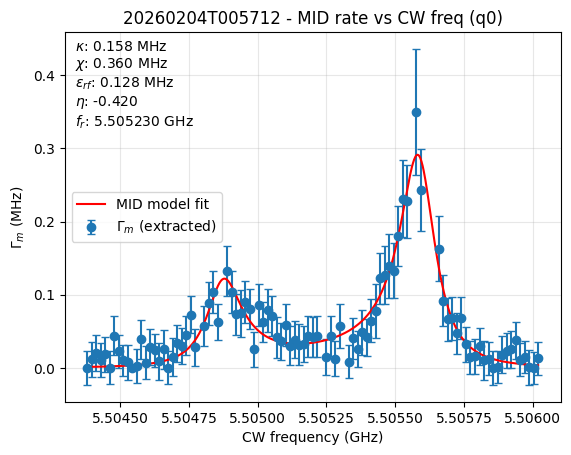

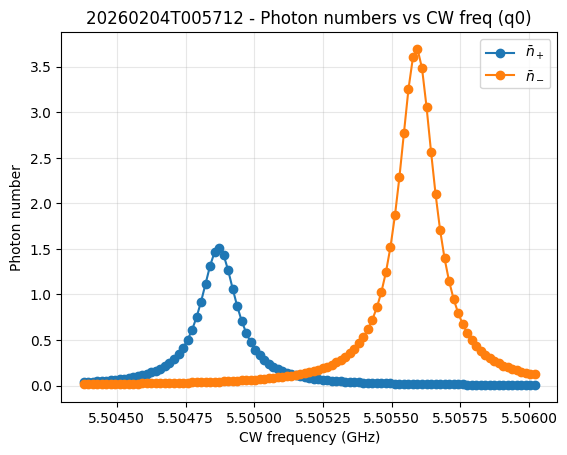

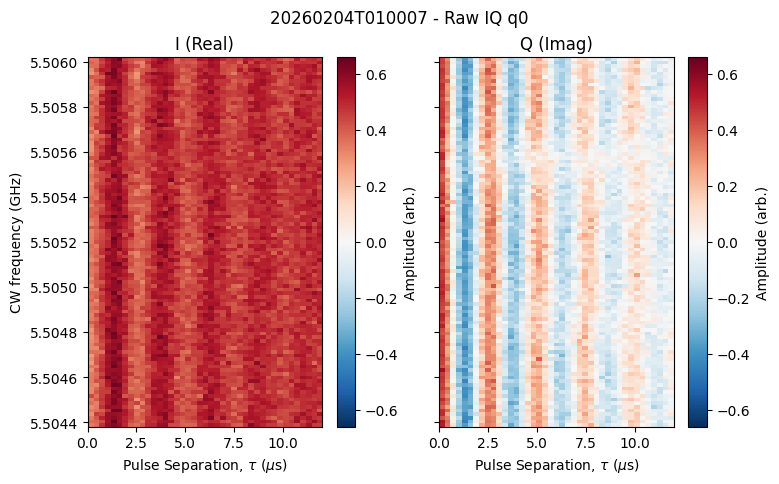

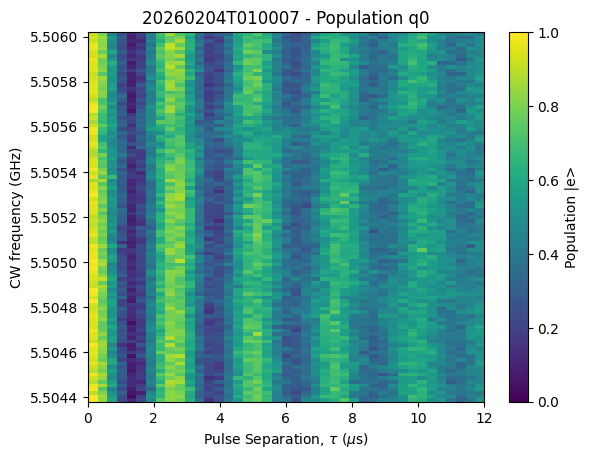

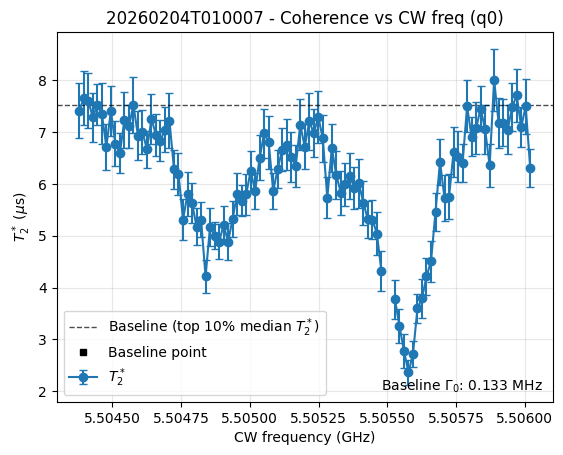

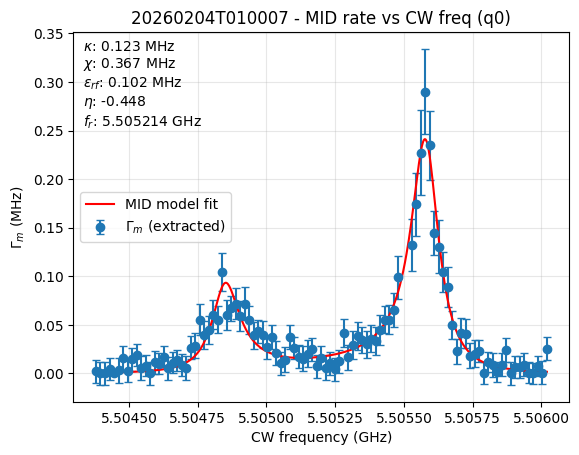

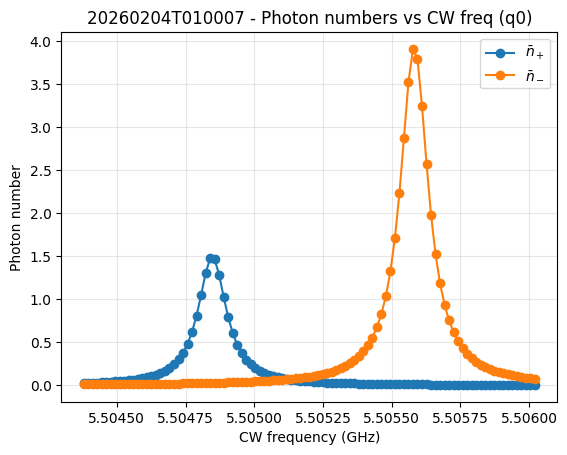

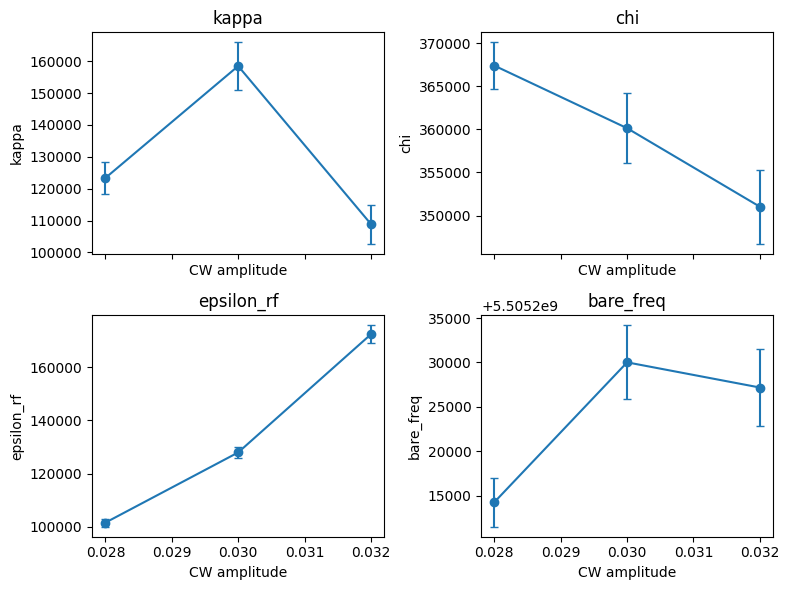

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

CW_amps = np.array([0.032, 0.030,  0.028])

results = {k: {"val": [], "err": []} for k in ["kappa","chi","epsilon_rf","bare_freq"]}

fit_results = []
for CW_amp in CW_amps:
    #####################################################################################
    options = new_coherence_spectroscopy.experiment_workflow.options()
    #workflow.show_fields(options)
    options.count(256)
    options.update(False)
    options.do_analysis(True)
    options.ring_up(50.0e-6)
    options.ring_down(10e-9)
    options.readout_section_length(100e-6)
    ######################################################################################
    co_spec = new_coherence_spectroscopy.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        bus=b,
        delays=np.linspace(0, 12e-6, 41),
        CW_frequencies= 5.5052e9+np.linspace(-0.82e6,0.82e6,101),#data point 최소 301확보필요
        CW_amplitude=CW_amp,   # <-- 
        CW_phase=0.0,
        detunings=0.4e6,
        temporary_parameters=temporary_parameters,
        options=options
    )
    co_spec_result = co_spec.run()
    fit = co_spec_result.tasks["analysis_workflow"].tasks["fit_mid_rate_data"].output["q0"]
    fit_results.append(fit)
    # fit 실패 대비
    if fit is None:
        for k in results:
            results[k]["val"].append(np.nan)
            results[k]["err"].append(np.nan)
        continue

    for k in results:
        p = fit.params[k]
        results[k]["val"].append(p.value)
        results[k]["err"].append(p.stderr if p.stderr is not None else np.nan)

# plot (4개 파라미터)
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)
axes = axes.ravel()
for ax, k in zip(axes, ["kappa","chi","epsilon_rf","bare_freq"]):
    ax.errorbar(CW_amps, results[k]["val"], yerr=results[k]["err"], fmt="o-", capsize=3)
    ax.set_title(k)
    ax.set_xlabel("CW amplitude")
    ax.set_ylabel(k)
plt.tight_layout()


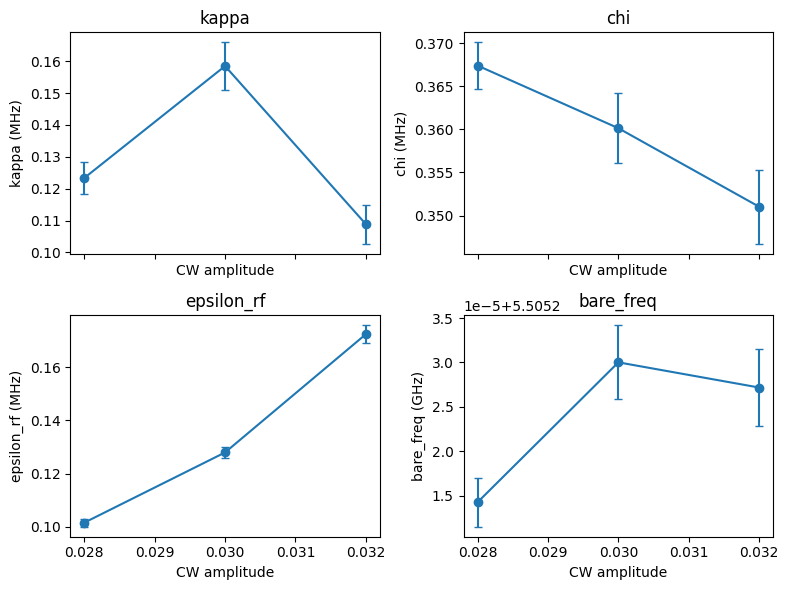

In [13]:
# 축 단위 설정
units = {
    "kappa": (1e6, "MHz"),
    "chi": (1e6, "MHz"),
    "epsilon_rf": (1e6, "MHz"),
    "bare_freq": (1e9, "GHz"),
}

fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)
axes = axes.ravel()

for ax, k in zip(axes, ["kappa","chi","epsilon_rf","bare_freq"]):
    scale, unit = units[k]
    y = np.array(results[k]["val"], dtype=float) / scale
    yerr = np.array(results[k]["err"], dtype=float) / scale

    ax.errorbar(CW_amps, y, yerr=yerr, fmt="o-", capsize=3)
    ax.set_title(k)
    ax.set_xlabel("CW amplitude")
    ax.set_ylabel(f"{k} ({unit})")

plt.tight_layout()

## Manual fitting

92
{'resonance_frequency_ge': 4207452435.8345494+/-2292.8786317683625, 'ge_T2_star': 8.00415003054944e-06+/-6.009242574333261e-07, 'selected_cw_frequency': np.float64(5505888800.0)}


(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

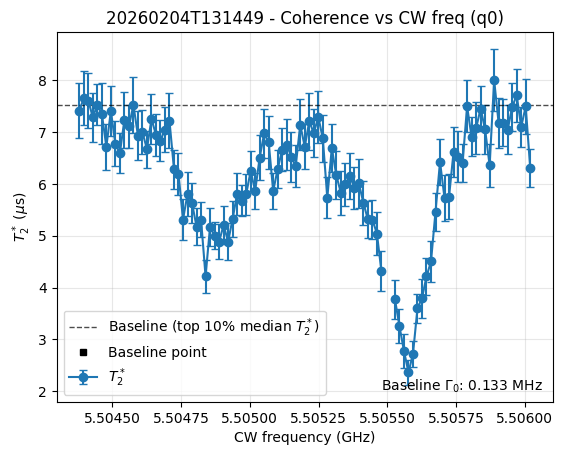

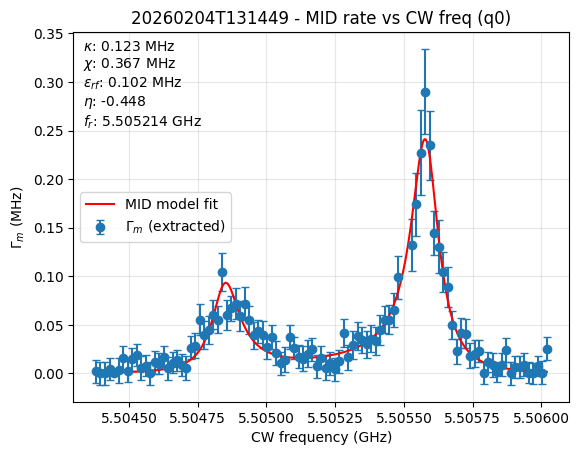

In [ ]:
# custom coherent spec analysis (offline from saved JSON)
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
from analysis import coherence_spectroscopy as coh_analysis

# Work whether the notebook cwd is repo root or this folder.
base = Path("examples/selectiveRIP")
if not base.exists():
    base = Path(".")

data_path = base / "fit-data.input.processed-data-dict.json"
if not data_path.exists():
    raise FileNotFoundError(f"Could not find {data_path} (cwd={Path.cwd()})")

with open(data_path, "r") as f:
    processed_raw = json.load(f)


def _pairs_to_complex(data_pairs: np.ndarray) -> np.ndarray:
    """Convert [..., real, imag, real, imag, ...] to complex array."""
    real = data_pairs[..., 0::2]
    imag = data_pairs[..., 1::2]
    return real + 1j * imag


processed_data_dict: dict[str, dict] = {}
for uid, entry in processed_raw.items():
    converted: dict = {}
    for key, value in entry.items():
        if key == "data_raw" and isinstance(value, dict) and "data" in value:
            data_pairs = np.asarray(value["data"], dtype=float)
            converted[key] = _pairs_to_complex(data_pairs)
        elif isinstance(value, list):
            converted[key] = np.asarray(value)
        else:
            converted[key] = value
    processed_data_dict[uid] = converted

# Use the qubit objects already defined earlier in the notebook.
q = qubits[0]

# IMPORTANT: set this to the detuning you used in the experiment.
detuning_used = 0.4e6

fit_results = coh_analysis.fit_data([q], processed_data_dict)
qubit_parameters = coh_analysis.extract_qubit_parameters([q], fit_results, detuning_used)
mid_fit_results = coh_analysis.fit_mid_rate_data([q], qubit_parameters)
maxima_fit_results = coh_analysis


print(qubit_parameters["per_frequency"][q.uid]["best_index"])
print(qubit_parameters["new_parameter_values"][q.uid])

# Plot both T2* and the MID rate fit.
fig_t2 = coh_analysis.plot_t2_star_vs_frequency([q], qubit_parameters)[q.uid]
fig_mid = coh_analysis.plot_MID_rate_vs_frequency([q], qubit_parameters, mid_fit_results)[q.uid]
fig_t2, fig_mid



In [24]:
import importlib
from analysis import coherence_spectroscopy as coh_analysis
importlib.reload(coh_analysis)

fit_results = coh_analysis.fit_data([q], processed_data_dict)
qubit_parameters = coh_analysis.extract_qubit_parameters([q], fit_results, detuning_used)

per = qubit_parameters["per_frequency"][q.uid]
print(per.keys())
print("minima_indices:", per.get("minima_indices"))


dict_keys(['frequencies', 't2_star', 'fit_frequency', 'best_index', 'mid_rate', 'mid_baseline_index', 'fit_success', 'minima_indices', 'minima_frequencies', 'minima_t2_star'])
minima_indices: [73, 28]


dict_keys(['q0', 'q0_minima_73', 'q0_minima_28'])
minima_indices: [73, 28]
fit_success count: 99


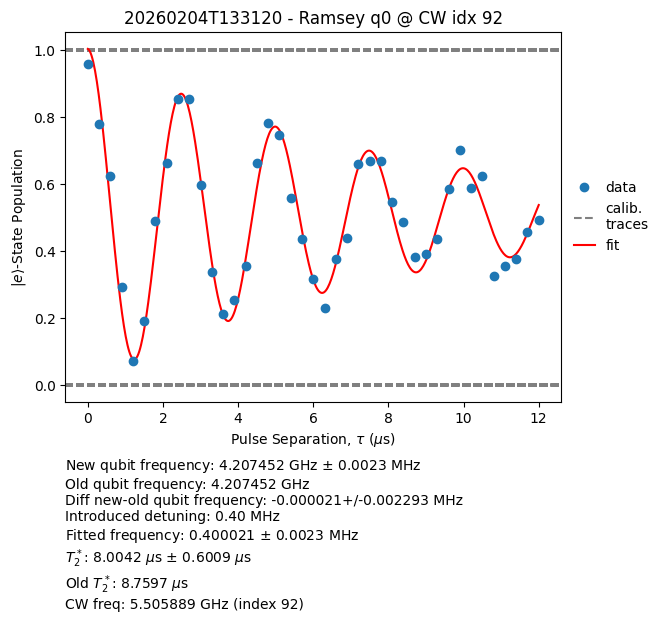

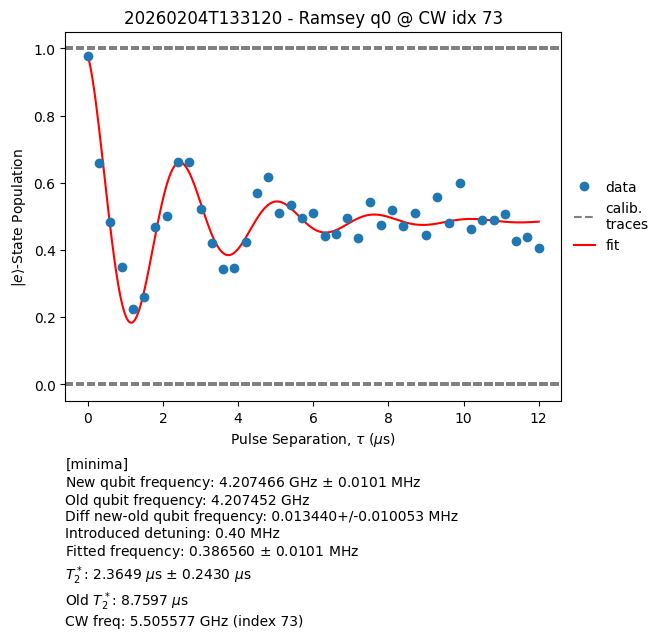

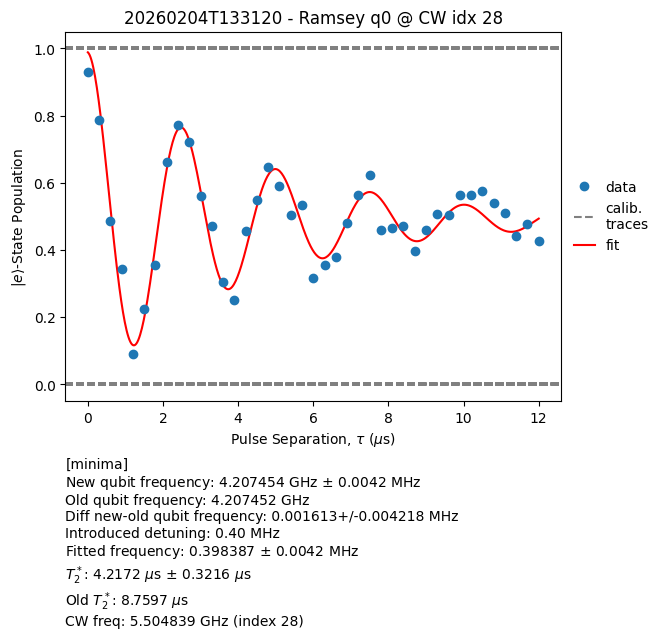

In [25]:
from laboneq_applications.analysis.options import PlotPopulationOptions

opts = PlotPopulationOptions()
opts.save_figures = False   # 중요
opts.close_figures = False

figs_pop = coh_analysis.plot_population(
    [q],
    processed_data_dict,
    fit_results,
    qubit_parameters,
    detuning_used,
    options=opts,
)


print(figs_pop.keys())  # 어떤 fig들이 있는지 확인
per = qubit_parameters["per_frequency"][q.uid]
print("minima_indices:", per.get("minima_indices"))
print("fit_success count:", np.sum(per.get("fit_success", [])))


# Amplitude calibration

## Rabi amp

In [ ]:
from laboneq_applications.experiments import amplitude_rabi
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

# temp_pars.ge_drive_length =64e-9
# temp_pars.drive_range= 10

temporary_parameters[q.uid] = temp_pars

#######################################################################
amplitudes = np.linspace(0.0, 1.0,101)
print(q.parameters.ge_drive_amplitude_pi)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi.experiment_workflow.options()
options.update(True)
options.use_cal_traces(True)
options.count(512)
#print(workflow.show_fields(options))

###################################################################
rabi_amp = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    amplitudes=amplitudes,
    options=options,
    temporary_parameters = temporary_parameters
)

rabi_amp_result = rabi_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_result.tasks['analysis_workflow'].output)

## X180

In [ ]:
from experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#temp_pars.ge_drive_amplitude_pi =0.64
#######################################################################
repetitions =np.arange(1,10) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(True)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

## X90

In [ ]:
from experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
options.count(1024)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

In [ ]:
# from helper import save_qubit_parameters
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters/", filename="COSPEC2")

# RB

In [ ]:
#from laboneq_applications.experiments import 
from experiments import single_qubit_randomized_benchmarking
q = qubits[0]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temporary_parameters[q.uid] = temp_pars

#############################################
options = single_qubit_randomized_benchmarking.experiment_workflow.options()
options.count(1024)
options.transition("ge")


rb = single_qubit_randomized_benchmarking.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    length_cliffords=[1,5,10,20,50],
    variations=50,
    options=options,
)

rb_result = rb.run()

#######################################################################

# Readout opt

## Resonator (Pulsed) Spec

In [ ]:
from experiments import resonator_spectroscopy

####################################################################################
q=qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_amplitude = 0.5
temporary_parameters[q.uid] = temp_pars
print(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#frequencies = q.parameters.readout_resonator_frequency + np.linspace(-10e6,10e6,501)
frequencies = temp_pars.readout_resonator_frequency + np.linspace(-3.0e6,3.0e6,501)
#####################################################################################
options = resonator_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(1024*3)
options.update(False)
options.use_cw(False) #qop.measure 
#options.fit_complex_resonator(False)
#options.fit_lorentzian(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec = resonator_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters=temporary_parameters,
    acquire_port_delay= 800e-9#1e-6
)
res_spec_result = res_spec.run()
res_spec_analysis_result = res_spec_result.tasks["analysis_workflow"]
pprint(res_spec_analysis_result.output)

## Dispersive shift

In [ ]:

from experiments import dispersive_shift

#######################################################################
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

#temp_pars.readout_resonator_frequency = 7.5582e9
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.count(1024)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,201),
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run() 
print(dispersive_result.tasks['analysis_workflow'].output)

## IQ Traj

In [ ]:
from experiments import iq_traj

####################################################################################
q=qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
#######################################################################
options = iq_traj.experiment_workflow.options()
options.count(2**14)
options.do_analysis(True)


#print(workflow.show_fields(options))

###################################################################
iq_t = iq_traj.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

iq_traj_result = iq_t.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_traj_result.tasks['analysis_workflow'].tasks['plot_iq_trajectories'].output[q.uid]

## IQ Blobs

In [ ]:

from experiments import iq_blobs

#######################################################################
q = qubits[0]

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.readout_length = 1.0e-6
temp_pars.readout_integration_length = 1.1e-6
# temp_pars.readout_amplitude = 0.7
# temp_pars.readout_integration_delay = 0.4e-6
# temp_pars.readout_resonator_frequency = 7.236e9
# temp_pars.readout_amplitude = 0.7

temporary_parameters[q.uid] = temp_pars
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = iq_blobs.experiment_workflow.options()
options.count(2**14)
#print(workflow.show_fields(options))

###################################################################
iq = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)
iq_blob_result = iq.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_blob_result.tasks['analysis_workflow'].tasks['plot_iq_blobs'].output[q.uid]
print(iq_blob_result.tasks['analysis_workflow'].output)


# SAVE QPU

In [12]:
from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
import time

t = time.localtime()
timestamp = time.strftime('%Y%m%d-%H%M', t)

filename = "co_spec0203"
save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}")

